# Imports

In [ ]:
# Install the necessary Python packages
!pip install numpy
!pip install tqdm
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install Pillow

In [1]:
import argparse, pdb
import numpy as np
import os
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from typing import Callable
import matplotlib.pyplot as plt

In [ ]:
# Download image dataset from Google Drive
! pip install gdown
! gdown 1Oeto_5xV_l4zVJIi1fFDsTrzE3y8mKUK
! unzip csci699_p2_dataset.zip

# Section 1: Generate embedding dataset

In [206]:
print(torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True))

Using cache found in /Users/yutai/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/yutai/mambaforge/envs/csci699_hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yutai/mambaforge/envs/csci699_hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [2]:
# Define some useful hyperparameters
IMG_SIZE = 299
device = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = ["cat", "dog", "neg"]

train_image_dir = "content/datasets/train"
test_image_dir = "content/datasets/test"

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),            # Resize to dimensions for Inception network
    transforms.ToTensor(),                              # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# See https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html for
# more details on usage.
train_img_folder = torchvision.datasets.ImageFolder(root=train_image_dir, transform=transform)

def to_numpy(tensor):
  return tensor.detach().cpu().numpy()

train_embs, train_labels = [], []
print('number of train images: ', len(train_img_folder))

######### Your code starts here #########
# We want to create a dataset of Inception-v3 embeddings.
# Hint: You can use the pretrained PyTorch Inception model here (https://pytorch.org/hub/pytorch_vision_inception_v3/)
# Iteration through the training images, use the bottleneck layers of Inception to generate embeddings
# and appending them to the respective lists: train_embs and train_labels
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.fc = nn.Identity()
model.eval()
for x, y in tqdm.tqdm(train_img_folder):
  # x: (3, 299, 299)
  # y: int
  train_embs.append(to_numpy(model(x.unsqueeze(0))))
  train_labels.append(y)


######### Your code ends here #########

train_embs = torch.from_numpy(np.concatenate(train_embs))
train_labels = torch.Tensor(train_labels)
train_dataset = TensorDataset(train_embs, train_labels) # (tensor(2048,), tensor(1,))

number of train images:  450


Using cache found in /Users/yutai/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/yutai/mambaforge/envs/csci699_hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yutai/mambaforge/envs/csci699_hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 450/450 [00:31<00:00, 14.42it/s]


# Section 2: Train linear classifier

In [10]:
# Define some training hyperparameters, feel free to modify these
num_epochs = 20
lr = 1e-3
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

######### Your code starts here #########
# We want to create a linear classifier which takes the embedding vectors as input.
# The training loop is already provided for you.

# 1. Define a new torch module for the classifier.
# 2. Define an appropriate optimizer from torch.optim.
# 3. Define the loss function for training the classifier.

embedding_dim = train_dataset[0][0].shape[0]
linear_classifier = nn.Linear(embedding_dim, len(LABELS))
optimizer = torch.optim.Adam(linear_classifier.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
######### Your code ends here #########


for epoch in range(num_epochs):
  # set model to training mode
  linear_classifier.train()
  train_loss = 0

  for batch_idx, (embeddings, class_label) in enumerate(train_loader):
    embeddings = embeddings.to(device)
    class_label = class_label.to(device)

    optimizer.zero_grad()

    probs = linear_classifier(embeddings)
    loss = loss_fn(probs, class_label.long())

    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader)))

Epoch: 0 Average loss: 0.9507
Epoch: 1 Average loss: 0.6560
Epoch: 2 Average loss: 0.5294
Epoch: 3 Average loss: 0.4026
Epoch: 4 Average loss: 0.3251
Epoch: 5 Average loss: 0.2758
Epoch: 6 Average loss: 0.2829
Epoch: 7 Average loss: 0.2278
Epoch: 8 Average loss: 0.2251
Epoch: 9 Average loss: 0.2224
Epoch: 10 Average loss: 0.2051
Epoch: 11 Average loss: 0.1715
Epoch: 12 Average loss: 0.1992
Epoch: 13 Average loss: 0.1583
Epoch: 14 Average loss: 0.1896
Epoch: 15 Average loss: 0.1874
Epoch: 16 Average loss: 0.1502
Epoch: 17 Average loss: 0.1291
Epoch: 18 Average loss: 0.1210
Epoch: 19 Average loss: 0.1172


# Section 3: Classify test images

In [14]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),            # Resize to dimensions for Inception network
    transforms.ToTensor(),                              # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load the test dataset
test_dataset = torchvision.datasets.ImageFolder(root=test_image_dir, transform=transform)

######### Your code starts here #########
# Classify all images in the test image folder
# Calculate the accuracy of the model on all of the images.
new_model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
new_model.fc = linear_classifier
new_model.eval()

pred_correct = 0
incorrect_idxes = []
for i, (x, y) in enumerate(tqdm.tqdm(test_dataset)):
    pred = torch.argmax(F.softmax(new_model(x.unsqueeze(0))))
    if pred == y:
        pred_correct += 1
    else:
        incorrect_idxes.append(i)

test_acc = pred_correct / len(test_dataset)
######### Your code ends here ########

print(f"Evaluated on {len(test_dataset)} samples.")
print(f"Accuracy: {test_acc * 100:.0f}%")

Using cache found in /Users/yutai/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/yutai/mambaforge/envs/csci699_hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yutai/mambaforge/envs/csci699_hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/150 [00:00<?, ?it/s]/var/folders/9m/vytm0m812zj1s4kfzll31zq00000gn/T/ipykernel_53405/2475040600.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argu

Evaluated on 150 samples.
Accuracy: 94%


In [15]:
print("Incorrectly classified images:")
print([test_dataset.imgs[i][0] for i in incorrect_idxes])

Incorrectly classified images:
['content/datasets/test/cat/005960.jpg', 'content/datasets/test/cat/009479.jpg', 'content/datasets/test/dog/001234.jpg', 'content/datasets/test/dog/003228.jpg', 'content/datasets/test/dog/004587.jpg', 'content/datasets/test/dog/005081.jpg', 'content/datasets/test/dog/008890.jpg', 'content/datasets/test/neg/004831.jpg', 'content/datasets/test/neg/008879.jpg']


# Section 4: Object Detection

In [52]:
def plot_classification(raw_img, classification_array, fname):
    nH, nW, _ = classification_array.shape
    aspect_ratio = float(raw_img.shape[0]) / raw_img.shape[1]
    plt.figure(figsize=(8, 8*aspect_ratio))
    p1 = plt.subplot(2,2,1)
    plt.imshow(classification_array[:,:,0], interpolation='none', cmap='jet')
    plt.title('%s probability' % LABELS[0])
    p1.set_aspect(aspect_ratio*nW/nH)
    plt.colorbar()
    p2 = plt.subplot(2,2,2)
    plt.imshow(classification_array[:,:,1], interpolation='none', cmap='jet')
    plt.title('%s probability' % LABELS[1])
    p2.set_aspect(aspect_ratio*nW/nH)
    plt.colorbar()
    p2 = plt.subplot(2,2,3)
    plt.imshow(classification_array[:,:,2], interpolation='none', cmap='jet')
    plt.title('%s probability' % LABELS[2])
    p2.set_aspect(aspect_ratio*nW/nH)
    plt.colorbar()
    plt.subplot(2,2,4)
    plt.imshow(raw_img)
    plt.savefig(fname)
    plt.show()

In [17]:
def compute_brute_force_classification(
    model: nn.Module,
    raw_img: np.ndarray,
    transforms,
    nH: int = 8,
    nW: int = 8
):
    '''
    This function returns the probabilities of each window.
    Inputs:
        model: Model which is used
        raw_img: H x W x 3 numpy array
        transforms: a sequence of transformations to apply to the image as preprocessing
        nH: number of windows in the vertical direction
        nW: number of windows in the horizontal direction
    Outputs:
        window_predictions: a (nH, nW, 3) np.array.
                            The last dim (size 3) is the probabilities
                            of each label (cat, dog, neg)
    '''
    ######### Your code starts here #########
    x = transforms(raw_img) # (3, H, W)
    _, H, W = x.shape
    window_height, window_width = H // nH, W // nW

    window_predictions = np.zeros((nH, nW, 3))
    for nh in range(nH):
        for nw in range(nW):
            window = x[:,nh * window_height:(nh+1)*window_height, nw * window_width:(nw+1)*window_width]
            window_padded = F.pad(window, (*([20]*4),0,0), mode='constant', value=0)
            # print(window.shape, window_padded.shape)
            logits = model(window_padded.unsqueeze(0)) #(1, 3)
            window_predictions[nh,nw] = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

    assert np.allclose(window_predictions.sum(axis=-1),1)

    ######### Your code ends here #########

    return window_predictions

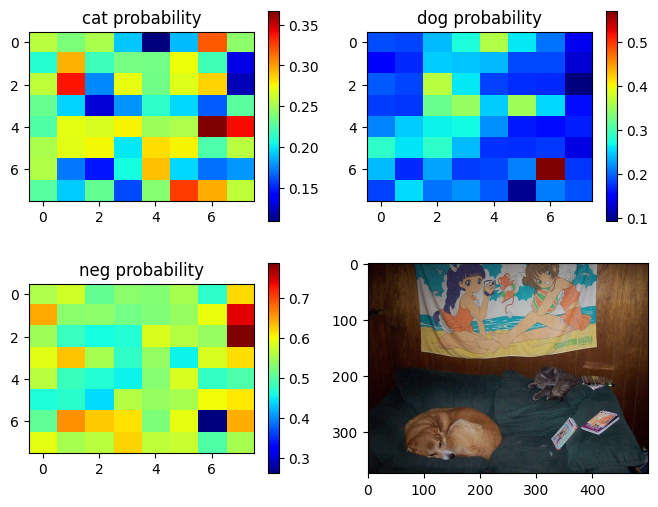

In [95]:
# Get raw image using PIL
catswithdogs_dir = "content/datasets/catswithdogs"
raw_img = np.array(Image.open(os.path.join(catswithdogs_dir, "002268.jpg")))

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),                  # Numpy array to PIL Image first
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to dimensions for Inception network
    transforms.ToTensor(),                    # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

window_predictions = compute_brute_force_classification(
    model= new_model,
    raw_img=raw_img,
    transforms=transform,
    nH=8,
    nW=8,
)

plot_classification(raw_img, window_predictions, "brute_force_classification.png")

In [54]:
def compute_convolutional_KxK_classification(
    model: nn.Module,
    classifier: nn.Module,
    raw_img: np.ndarray,
    transforms
):
    """
    Computes probabilities for each window based on the convolution layer of Inception
    Inputs:
      model: model which is used
      raw_img: numpy array of image

    Outputs:
      predictions: a (K, K, 3) np.array.
    """
    x = transform(raw_img)
    ######### Your code starts here #########
    out = model(x.unsqueeze(0)) # (1, 131072)

    # embedding size is 2048 (see train_embs.shape), 8x8 is the output size of the last conv layer
    out = out.reshape(1*8*8, 2048)
    out = F.softmax(classifier(out), dim=1)
    predictions = out.detach().cpu().numpy().squeeze().reshape(8,8,-1)
  
    assert np.allclose(predictions.sum(axis=-1),1)
    ######### Your code ends here #########

    return predictions

Using cache found in /Users/yutai/.cache/torch/hub/pytorch_vision_v0.10.0


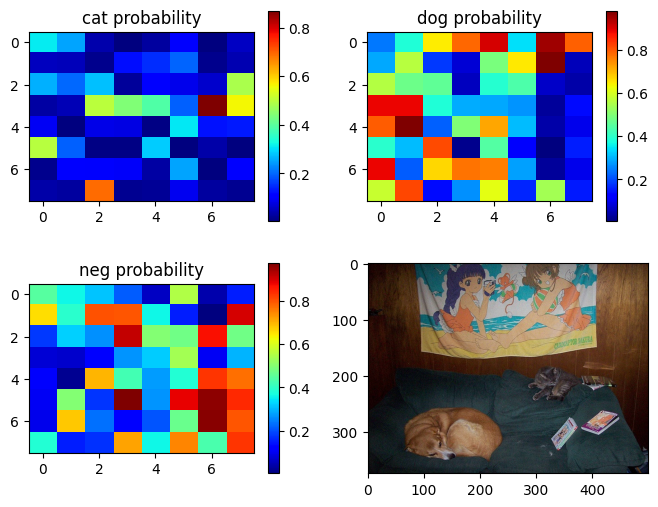

In [56]:
# Get raw image, do not apply transform
catswithdogs_dir = "content/datasets/catswithdogs"
raw_img = np.array(Image.open(os.path.join(catswithdogs_dir, "002268.jpg")))

transform = transforms.Compose([
    transforms.ToPILImage(),                  # Numpy array to PIL Image first
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to dimensions for Inception network
    transforms.ToTensor(),                    # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()
for component in ["avgpool", "dropout", "fc"]:
    assert component in model._modules
    model._modules[component] = nn.Identity()
# model.fc = linear_classifier

window_predictions = compute_convolutional_KxK_classification(
    model= model,
    classifier = linear_classifier,
    raw_img=raw_img,
    transforms=transform,
)

plot_classification(raw_img, window_predictions, "convolutional_KxK_classification.png")

# Section 5: Saliency Mapping

Using cache found in /Users/yutai/.cache/torch/hub/pytorch_vision_v0.10.0


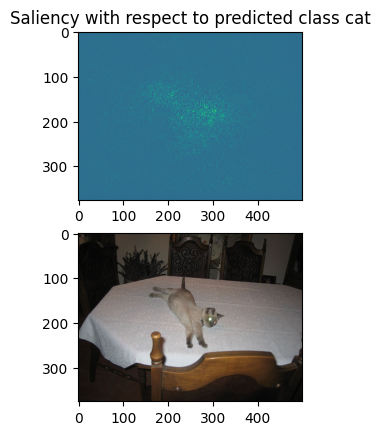

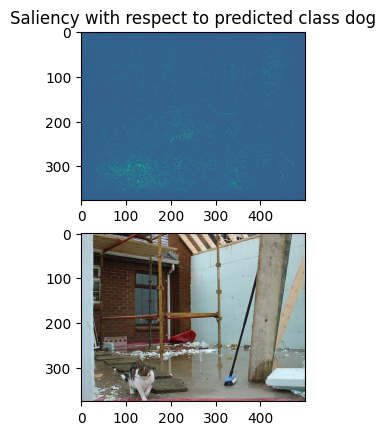

In [89]:
def compute_and_plot_saliency(
    model: nn.Module,
    raw_img: np.ndarray,
    fname: str,
):
    """
    This function computes and plots the saliency plot.
    You need to compute the matrix M detailed in section 3.1 in
    K. Simonyan, A. Vedaldi, and A. Zisserman,
    "Deep inside convolutional networks: Visualising imageclassification models and saliency maps,"
    2013, Available at https://arxiv.org/abs/1312.6034.

    Inputs:
      model: model which is used
      raw_img: numpy array of image
    """
    ######### Your code starts here #########
    transform = transforms.Compose([
        transforms.ToPILImage(),                  # Numpy array to PIL Image first
        # transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to dimensions for Inception network
        transforms.ToTensor(),                    # Convert PIL Image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    ])

    x = transform(raw_img)
    x.requires_grad = True

    logits = model(x.unsqueeze(0)) # (1, 3)
    top_class = torch.argmax(F.softmax(logits, dim=1))

    logits[:,top_class].backward()
    M = torch.max(x.grad, dim=0)[0] # only want max value, not index

    ######### Your code ends here #########

    # Code to save the saliency plot
    plt.subplot(2, 1, 1)
    plt.imshow(M)
    plt.title('Saliency with respect to predicted class %s' % LABELS[top_class])
    plt.subplot(2, 1, 2)
    plt.imshow(raw_img)
    plt.savefig(fname)
    plt.show()



# Get raw image, do not apply transform
"""
['content/datasets/test/cat/005960.jpg',
'content/datasets/test/cat/009479.jpg',
'content/datasets/test/dog/001234.jpg',
'content/datasets/test/dog/003228.jpg',
'content/datasets/test/dog/004587.jpg',
'content/datasets/test/dog/005081.jpg',
'content/datasets/test/dog/008890.jpg',
'content/datasets/test/neg/004831.jpg',
'content/datasets/test/neg/008879.jpg']
"""

catswithdogs_dir = "content/datasets/catswithdogs"

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.fc = linear_classifier
model.eval()

raw_img = np.array(Image.open(os.path.join(test_image_dir, "cat/004149.jpg")))
compute_and_plot_saliency(
    model = model,
    raw_img = raw_img,
    fname = "saliency_correct.png",
)

raw_img = np.array(Image.open(os.path.join(test_image_dir, "cat/005960.jpg")))
compute_and_plot_saliency(
    model = model,
    raw_img = raw_img,
    fname = "saliency_incorrect.png",
)
